[Reference](https://medium.com/@vladimir.prus/time-series-trend-detection-with-bayesian-methods-8a2162bcac6a)

In [1]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from google.colab import files

In [3]:
data = np.array([10]* 7 + [15, 10, 19, 17, 20, 15, 16] + [18, 17, 15, 18, 20, 15, 16] + [15, 16, 18, 18, 19, 13, 14])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

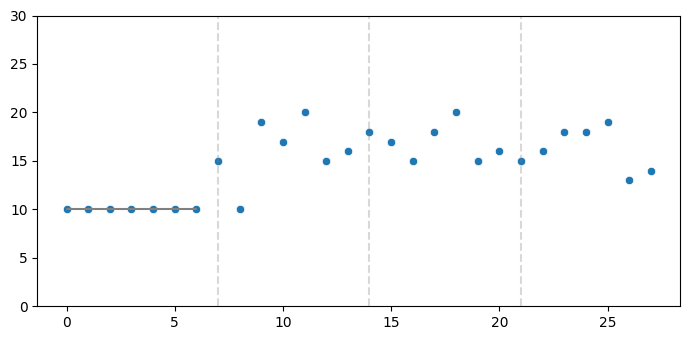

In [4]:
def plot(trends, filename):
  f, ax = plt.subplots(1, 1, figsize=(14/2,7/2), dpi=100)

  sns.set_style('dark')
  sns.scatterplot(x=np.array(range(0, len(data))), y=data, ax=ax)

  ax.set_ylim(0, 30)

  for (week, trend) in enumerate(trends):
    ax.plot([0 + week * 7, 6 + week * 7], [trend, trend], color='gray')

  ax.plot([7, 7], [0, 30], color='gray', linestyle='--', alpha=0.3)
  ax.plot([14, 14], [0, 30], color='gray', linestyle='--', alpha=0.3)
  ax.plot([21, 21], [0, 30], color='gray', linestyle='--', alpha=0.3)  

  f.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
  f.tight_layout()
  ax.set_xmargin(0)
  f.savefig(filename, dpi=100, bbox_index='tight')
  files.download(filename)

plot([10], "initial.png")

In [5]:
import scipy.stats

scipy.stats.ttest_1samp(a=data[7:14], popmean=10)

Ttest_1sampResult(statistic=4.860555523805895, pvalue=0.0028212592801565937)


[ 5.41521218  1.32171058 -0.51981033]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

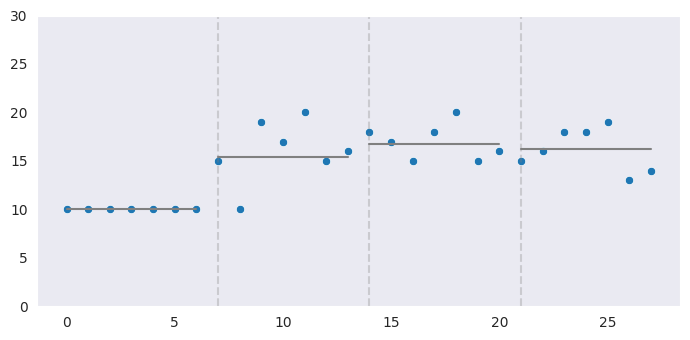

In [6]:
with pm.Model() as model:
  # The trend on the first week is pretty clear
  trend_0 = 10
  # Assume that each Monday, we have a random change in trend, and that
  # change is normally distributed random variable
  changes = pm.Normal("changes", mu=0, sigma=10, shape=3)
  # Compute absolute trends for subsequent weeks
  trend_1 = trend_0 + changes[0]
  trend_2 = trend_1 + changes[1]
  trend_3 = trend_2 + changes[2]

  # Assume that daily measurements are normally distributed around week's trend
  # Pass the observed data, so that PyMC can infer back the likely
  # values for the 'changes' variable
  actual_1 = pm.Normal("actual 1", mu=trend_1, sigma=10, observed=data[7:14])
  actual_2 = pm.Normal("actual 2", mu=trend_2, sigma=10, observed=data[14:21])
  actual_3 = pm.Normal("actual 3", mu=trend_3, sigma=10, observed=data[21:28])

  # Compute a point estimate
  map = pm.find_MAP()

# Show the most likely values for week-to-week changes
print(map['changes'])
# Convert week-to-week changes to absolute weekly levels
trends = np.concatenate(([10], map['changes'].cumsum() + 10))
plot(trends, "normal-sigma-10.png")


[3.34766177 1.67696816 0.43207454]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

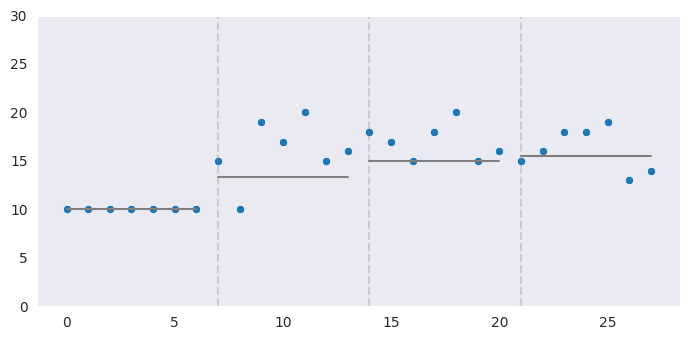

In [7]:
with pm.Model() as model:
  trend_0 = 10
  changes = pm.Normal("changes", mu=0, sigma=3, shape=3)
  trend_1 = trend_0 + changes[0]
  trend_2 = trend_1 + changes[1]
  trend_3 = trend_2 + changes[2]

  actual_1 = pm.Normal("actual 1", mu=trend_1, sigma=10, observed=data[7:14])
  actual_2 = pm.Normal("actual 2", mu=trend_2, sigma=10, observed=data[14:21])
  actual_3 = pm.Normal("actual 3", mu=trend_3, sigma=10, observed=data[21:28])

  map = pm.find_MAP()

# Show the most likely values for week-to-week changes
print(map['changes'])
# Convert week-to-week changes to absolute weekly levels
trends = np.concatenate(([10], map['changes'].cumsum() + 10))
plot(trends, "normal-sigma-3.png")

3.0
2.9999999999999996


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

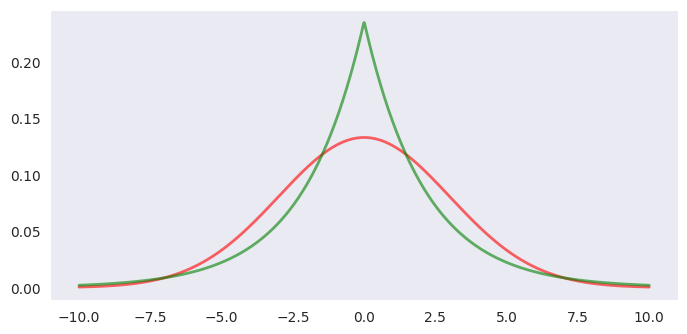

In [8]:
from scipy.stats import laplace, norm
import math

f, ax = plt.subplots(1, 1, figsize=(14/2,7/2), dpi=100)
f.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
f.tight_layout()

nscale = 3
lscale = 3/math.sqrt(2)

print(norm.std(loc = 0, scale = nscale))
print(laplace.std(loc = 0, scale = lscale))

x = np.linspace(-10, 10, 1000)
ax.plot(x, norm.pdf(x, loc = 0, scale = nscale),
       'r-', lw=2, alpha=0.6, label='norm pdf')
ax.plot(x, laplace.pdf(x, loc = 0, scale = lscale), 'g-', lw=2, alpha=0.6)


f.savefig("normal-vs-laplace.png", dpi=100, bbox_index='tight')
files.download("normal-vs-laplace.png")


[5.69020714e+00 1.87704650e-04 7.52844191e-09]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

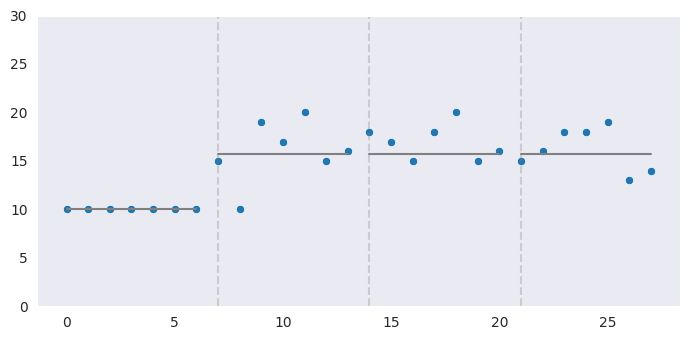

In [9]:
with pm.Model() as model:
  trend_0 = 10
  # b parameter of 10/math.sqrt(2) results in the same variance
  # as the normal distribution with sigma of 10 that we tried initially.
  # only the shape is different
  changes = changes = pm.Laplace("changes", mu=0, b=10/math.sqrt(2), shape=3)
  math.sqrt(2)
  trend_1 = trend_0 + changes[0]
  trend_2 = trend_1 + changes[1]
  trend_3 = trend_2 + changes[2]

  actual_1 = pm.Normal("actual 1", mu=trend_1, sigma=10, observed=data[7:14])
  actual_2 = pm.Normal("actual 2", mu=trend_2, sigma=10, observed=data[14:21])
  actual_3 = pm.Normal("actual 3", mu=trend_3, sigma=10, observed=data[21:28])

  map = pm.find_MAP()

# Show the most likely values for week-to-week changes
print(map['changes'])
# Convert week-to-week changes to absolute weekly levels
trends = np.concatenate(([10], map['changes'].cumsum() + 10))
plot(trends, "laplace.png")